## Comparing RAG on a Code dataset using Vector Search and KnowledgeGraph Search

`LlamaIndex` for LLM Orchestration
`NetworkX`, `Neo4j`, `AST` for Knowledge Graph

In [1]:
import os
import json
import ast
import networkx as nx
import matplotlib.pyplot as plt
from py2neo import Graph, Node, Relationship

import dotenv
import logging.config
import logging
from IPython.display import Markdown

from llama_index.graph_stores.neo4j import Neo4jGraphStore
from llama_index.llms.bedrock import Bedrock
from llama_index.embeddings.bedrock import BedrockEmbedding
from llama_index.retrievers.bedrock import AmazonKnowledgeBasesRetriever

from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.indices.property_graph import TextToCypherRetriever
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore
from llama_index.core import (
    PropertyGraphIndex,
    StorageContext,
    Settings,
    QueryBundle,
)
from llama_index.core.schema import NodeWithScore
from llama_index.core.retrievers import (
    BaseRetriever,
)
from llama_index.core.llms import ChatMessage


dotenv.load_dotenv()
logging.basicConfig(level=logging.INFO)


## Extract the Knowledge Graph from the Python Requests Library Codes

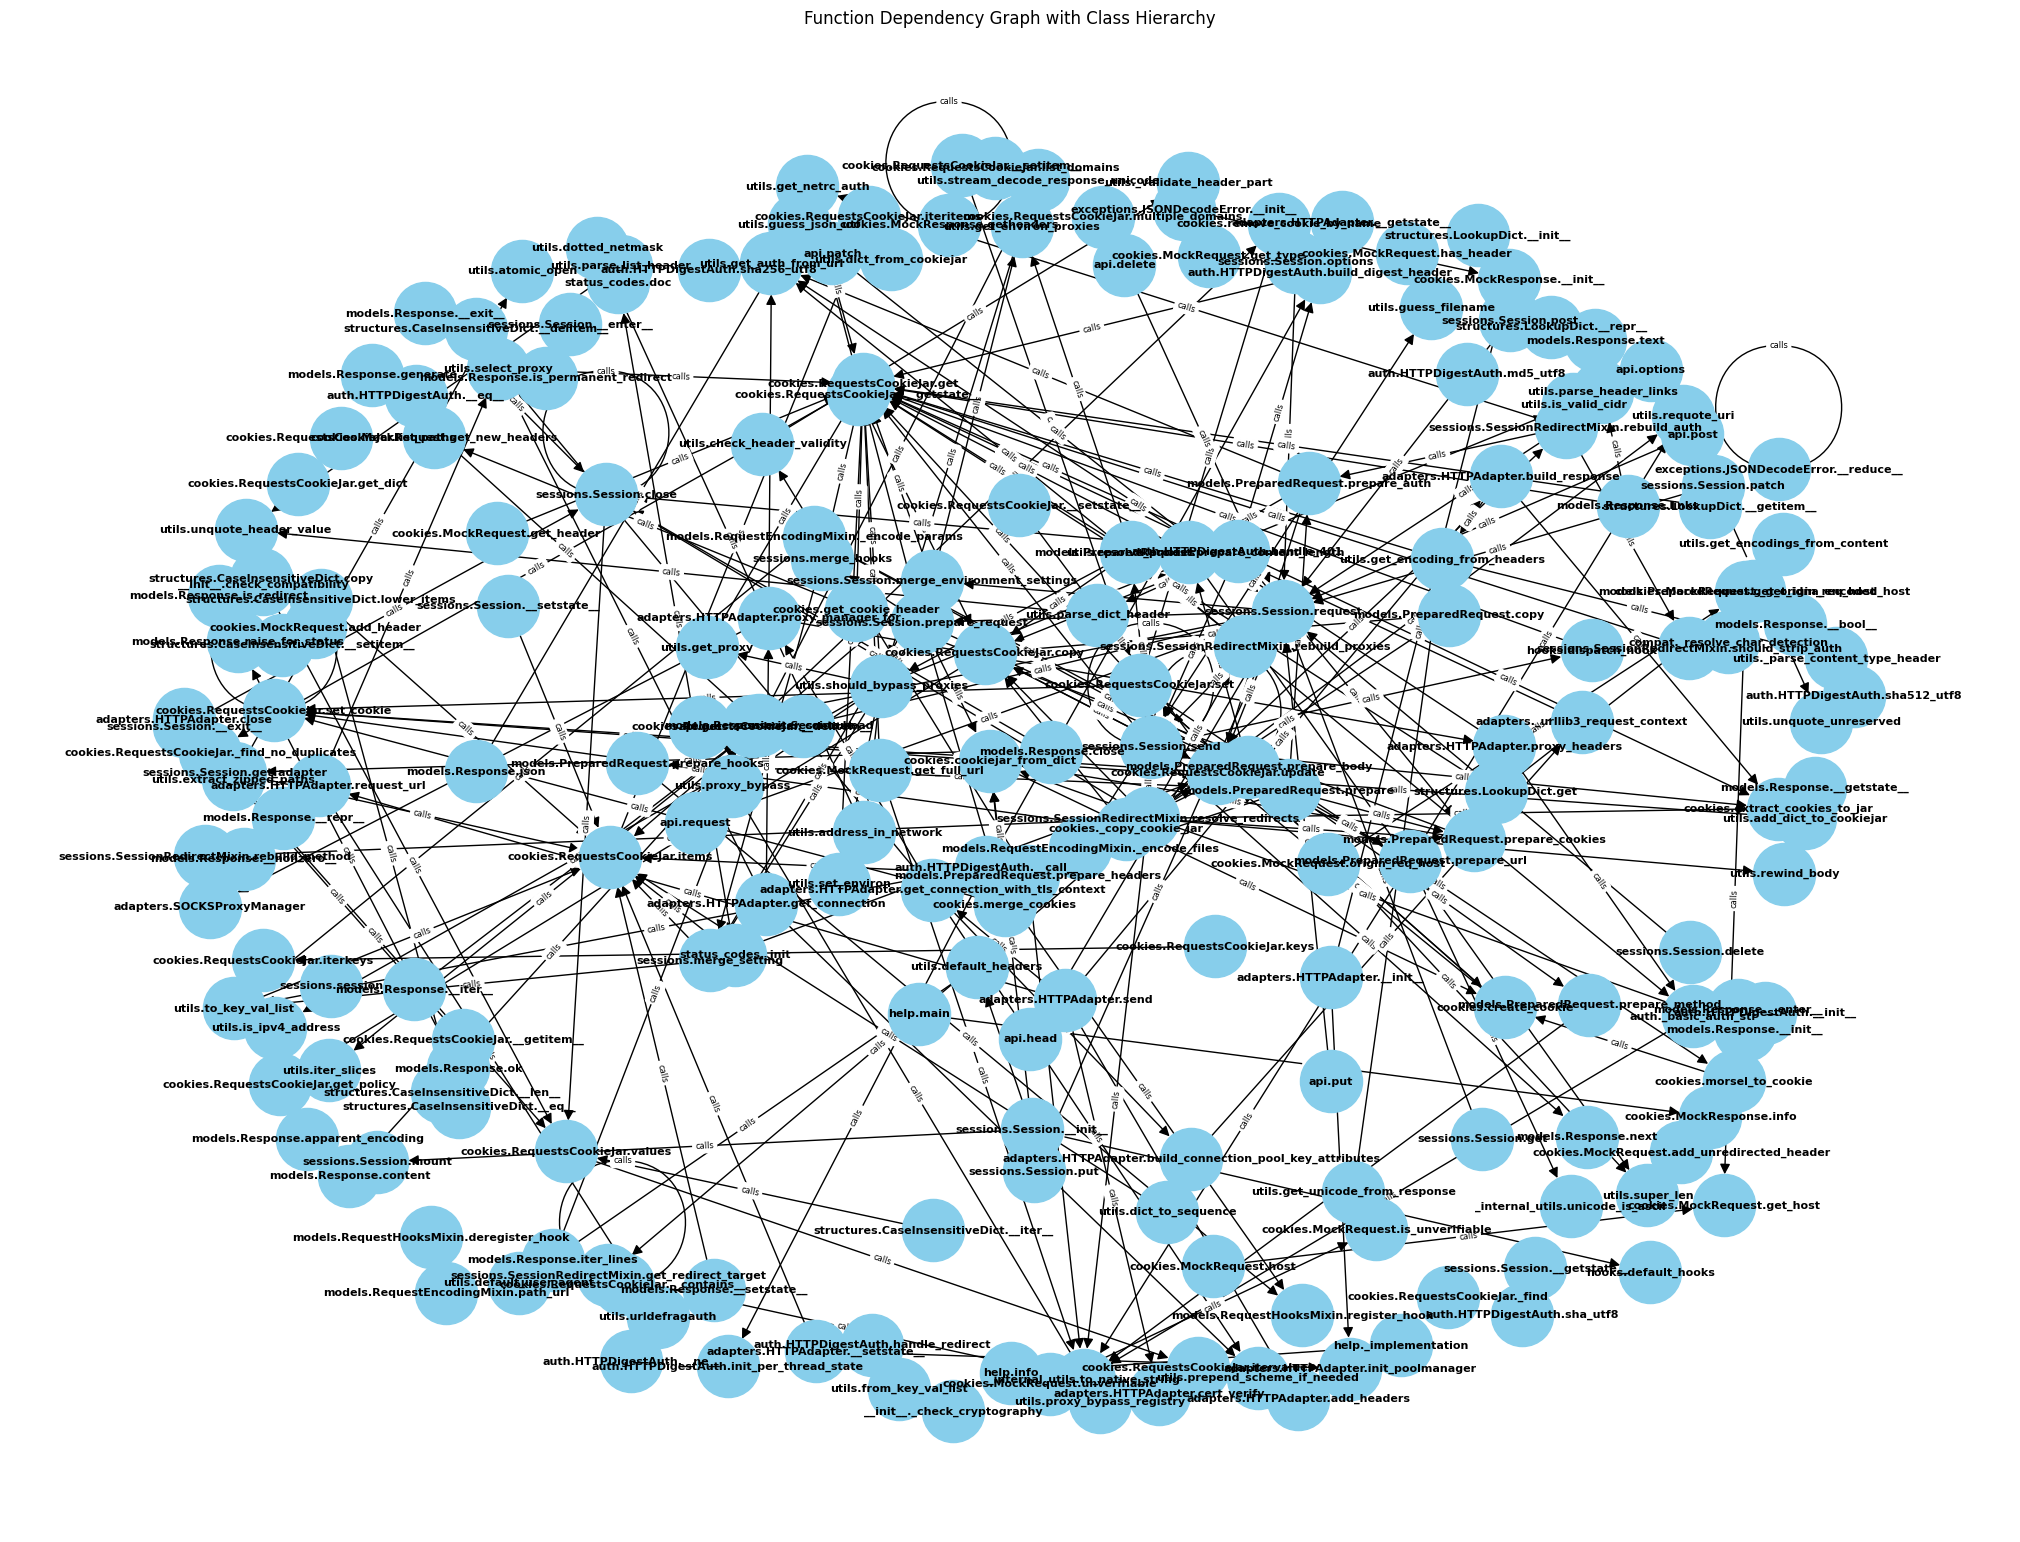

In [2]:
class FunctionVisitor(ast.NodeVisitor):
    """AST visitor to collect functions, classes, their dependencies, imports, and code."""
    def __init__(self, source_lines):
        self.current_class = []
        self.functions = {}  # {function_name: {class, dependencies, code}}
        self.classes = {}    # {class_name: {code, methods}}
        self.imports = []
        self.source_lines = source_lines

    def visit_ClassDef(self, node):
        # Extract class code
        class_code = self._get_node_code(node)
        self.classes[node.name] = {
            'code': class_code,
            'methods': []
        }
        self.current_class.append(node.name)
        self.generic_visit(node)  # Visit nested functions and classes
        self.current_class.pop()

    def visit_FunctionDef(self, node):
        # Extract function code
        func_code = self._get_node_code(node)
        parent_class = self.current_class[-1] if self.current_class else None
        called_functions = self._collect_called_functions(node)

        # Add to functions dict
        self.functions[node.name] = {
            'class': parent_class,
            'dependencies': called_functions,
            'code': func_code
        }

        # If part of a class, add to class's methods
        if parent_class:
            self.classes[parent_class]['methods'].append(node.name)

        self.generic_visit(node)

    def _collect_called_functions(self, node):
        called = set()
        for subnode in ast.walk(node):
            if isinstance(subnode, ast.Call):
                if isinstance(subnode.func, ast.Name):
                    called.add(subnode.func.id)
                elif isinstance(subnode.func, ast.Attribute):
                    called.add(subnode.func.attr)
        return list(called)

    def _get_node_code(self, node):
        # Get the source code for a node using its line numbers
        start_line = node.lineno - 1  # Convert to 0-based index
        end_line = node.end_lineno    # end_lineno is inclusive
        code_lines = self.source_lines[start_line:end_line]
        return '\n'.join(code_lines)

    def visit_Import(self, node):
        """Collect import statements."""
        for alias in node.names:
            self.imports.append(alias.name)
        self.generic_visit(node)

    def visit_ImportFrom(self, node):
        """Collect from-import statements."""
        module = node.module if node.module else ""
        for alias in node.names:
            full_name = f"{module}.{alias.name}".strip(".")
            self.imports.append(full_name)
        self.generic_visit(node)

def parse_python_file(file_path):
    """Parse a Python file to extract functions, classes, dependencies, imports, and code."""
    with open(file_path, "r") as f:
        source = f.read()
        source_lines = source.split('\n')
        tree = ast.parse(source, filename=file_path)

    visitor = FunctionVisitor(source_lines)
    visitor.visit(tree)
    return visitor.functions, visitor.imports, visitor.classes

def build_function_dependency_graph(folder_path):
    """Build a dependency graph and collect code for functions and classes."""
    G = nx.DiGraph()
    file_info_map = {}
    global_functions_code = {}
    global_classes_code = {}

    # First pass: Collect functions, classes, and their code
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".py"):
                file_path = os.path.join(root, file)
                functions, imports, classes = parse_python_file(file_path)

                # Calculate module name
                relative_path = os.path.relpath(file_path, folder_path)
                module_path = os.path.splitext(relative_path)[0]
                module_name = module_path.replace(os.path.sep, '.')

                # Process functions
                for func_name, func_info in functions.items():
                    parent_class = func_info['class']
                    # Construct full function identifier
                    if parent_class:
                        full_func_name = f"{module_name}.{parent_class}.{func_name}"
                    else:
                        full_func_name = f"{module_name}.{func_name}"
                    # Add to global_functions_code
                    global_functions_code[full_func_name] = func_info['code']
                    # Add node to graph
                    G.add_node(full_func_name, type="function")

                # Process classes
                for class_name, class_info in classes.items():
                    full_class_name = f"{module_name}.{class_name}"
                    # Add to global_classes_code
                    global_classes_code[full_class_name] = class_info['code']

                # Store file info for dependency resolution
                file_info_map[file_path] = {
                    'module': module_name,
                    'functions': functions,
                    'imports': imports,
                    'classes': classes
                }

    # Second pass: Add dependencies between nodes
    for file_path, file_info in file_info_map.items():
        module_name = file_info['module']
        functions = file_info['functions']

        for func_name, func_info in functions.items():
            parent_class = func_info['class']
            dependencies = func_info['dependencies']

            # Create current function's full name
            if parent_class:
                current_node = f"{module_name}.{parent_class}.{func_name}"
            else:
                current_node = f"{module_name}.{func_name}"

            # Check each dependency
            for dep_name in dependencies:
                found = False
                # Look through all files to find the dependency
                for dep_file_path, dep_file_info in file_info_map.items():
                    dep_module = dep_file_info['module']
                    dep_functions = dep_file_info['functions']
                    dep_classes = dep_file_info['classes']

                    # Check if dependency is a function in this module
                    if dep_name in dep_functions:
                        dep_info = dep_functions[dep_name]
                        dep_class = dep_info['class']
                        if dep_class:
                            dep_node = f"{dep_module}.{dep_class}.{dep_name}"
                        else:
                            dep_node = f"{dep_module}.{dep_name}"
                        G.add_edge(current_node, dep_node, relation="calls")
                        found = True
                        break
                    # Check if dependency is a class (methods are handled via function dependencies)
                    elif dep_name in dep_classes:
                        # Handle class dependencies if needed
                        pass

                if not found:
                    # Optional: Handle external dependencies
                    pass

    return G, global_functions_code, global_classes_code

def visualize_graph(G):
    """Visualize the dependency graph."""
    pos = nx.spring_layout(G, k=0.5, iterations=50)
    plt.figure(figsize=(20, 15))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
            font_size=8, font_weight="bold", arrowsize=15)
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)
    plt.title("Function Dependency Graph with Class Hierarchy")
    plt.show()

# Example usage
if __name__ == "__main__":
    folder_path = "./requests-main/src/requests"  # Update this path
    graph, functions_code, classes_code = build_function_dependency_graph(folder_path)
    visualize_graph(graph)
    # Example access to code:
    # print(functions_code['requests.models.Request.__init__'])
    # print(classes_code['requests.models.Request'])

## Upload the Knowledge Graph to Neo4j database

In [3]:

# Connect to the Neo4j database
username = os.environ["NEO4J_USERNAME"]
password = os.environ["NEO4J_PASSWORD"]
url = os.environ["NEO4J_URL"]

graph_db = Graph(url, auth=(username, password))

# Clear the database (optional, for a clean slate)
graph_db.delete_all()

# Upload the graph to Neo4j
for node, data in graph.nodes(data=True):
    print(node, data)
    node_properties = {"name": node, **data}
    graph_db.merge(Node("Function", **node_properties), "Function", "name")

for u, v, edge_data in graph.edges(data=True):
    print(u, v, edge_data)
    node_u = graph_db.nodes.match("Function", name=u).first()
    node_v = graph_db.nodes.match("Function", name=v).first()
    rel_type = edge_data.get("relationship_type", "CALLS")
    rel = Relationship(node_u, rel_type, node_v)
    graph_db.merge(rel)


cookies.MockResponse.__init__ {'type': 'function'}
cookies.MockRequest.get_type {'type': 'function'}
cookies.MockRequest.get_host {'type': 'function'}
cookies.MockRequest.get_origin_req_host {'type': 'function'}
cookies.MockRequest.get_full_url {'type': 'function'}
cookies.MockRequest.is_unverifiable {'type': 'function'}
cookies.MockRequest.has_header {'type': 'function'}
cookies.MockRequest.get_header {'type': 'function'}
cookies.MockRequest.add_header {'type': 'function'}
cookies.MockRequest.add_unredirected_header {'type': 'function'}
cookies.MockRequest.get_new_headers {'type': 'function'}
cookies.MockRequest.unverifiable {'type': 'function'}
cookies.MockRequest.origin_req_host {'type': 'function'}
cookies.MockRequest.host {'type': 'function'}
cookies.MockResponse.info {'type': 'function'}
cookies.MockResponse.getheaders {'type': 'function'}
cookies.extract_cookies_to_jar {'type': 'function'}
cookies.get_cookie_header {'type': 'function'}
cookies.remove_cookie_by_name {'type': 'fun

## Define the Knowledge Graph and Vector Database using Llama Index

In [54]:

llm = Bedrock(
    model="anthropic.claude-3-5-sonnet-20240620-v1:0",
    region_name="us-east-1",
)
embed_model = BedrockEmbedding(model="amazon.titan-embed-text-v1",
                               region_name="us-east-1")

Settings.llm = llm
Settings.embed_model = embed_model

# Neo4jGraphStore (Graph Search)

graph_store = Neo4jGraphStore(username=username, password=password, url=url)
storage_context = StorageContext.from_defaults(graph_store=graph_store)


property_graph_store = Neo4jPropertyGraphStore(username=username, password=password, url=url)


index = PropertyGraphIndex.from_existing(
    property_graph_store=property_graph_store,
    storage_context=storage_context,
    embed_model=embed_model,
    llm=llm,
)

# Define a custom Cypher template with LIMIT 5
custom_cypher_template = (
    "Given the schema, generate a Cypher query to answer the question. ONLY OUTPUT THE QUERY.\n"
    "Always include `LIMIT 5` in the query to restrict the results to 5 nodes.\n"
    "Schema: {schema}\n"
    "Question: {question}\n"
    "Cypher Query:"
)

# Initialize the TextToCypherRetriever with the custom template
kg_retriever = TextToCypherRetriever(
    index.property_graph_store,
    text_to_cypher_template=custom_cypher_template,
)

# Bedrock knowledge base (vector search)

bedrock_retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=os.environ["BEDROCK_KB_ID"],
    retrieval_config={
        "vectorSearchConfiguration": {
            "numberOfResults": 5,
            "overrideSearchType": "HYBRID",
        }
    },
)

INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.
INFO:neo4j.notifications:Received notification from DBMS server: {severity: INFORMATION} {code: Neo.ClientNotification.Schema.IndexOrConstraintAlreadyExists} {category: SCHEMA} {title: `CREATE CONSTRAINT IF NOT EXISTS FOR (e:Entity) REQUIRE (e.id) IS UNIQUE` has no effect.} {description: `CONSTRAINT constraint_1ed05907 FOR (e:Entity) REQUIRE (e.id) IS UNIQUE` already exists.} {position: None} for query: '\n                CREATE CONSTRAINT IF NOT EXISTS FOR (n:Entity) REQUIRE n.id IS UNIQUE;\n                '
INFO:botocore.credentials:Found credentials in environment variables.


In [ ]:
class CustomRetriever(BaseRetriever):
    """Custom retriever that performs kg and vector retrievals."""

    def __init__(
        self,
        kg_retriever: TextToCypherRetriever,
        function_code: dict,
        llm: Bedrock,
    ) -> None:
        """Init params."""

        self._kg_retriever = kg_retriever
        self._function_code = function_code
        self._llm = llm
        super().__init__()

    def _build_code_context(self, function_names: list[str]) -> str:
        code_context = ""
        for function_name in function_names:
            temp = "<function_name>" + function_name + "</function_name>" + "\n" + "<code>" + functions_code.get(function_name, "Code Not Found!") + "</code>" + "\n"
            code_context += temp
        return code_context

    def _retrieve(self, query_bundle: QueryBundle) -> list[NodeWithScore]:
        """Retrieve nodes given query."""
        kg_nodes = self._kg_retriever.retrieve(query_bundle)
        print("-"*50)
        print(f"KG nodes: {len(kg_nodes)}")
        print("-"*50)

        # Add the code context to the KG node
        response = llm.chat([ChatMessage(role="user", content=f"Extract the name of the functions from the Cypher response. only output as valid json list. {kg_nodes[0].text}")])
        function_names = json.loads(response.message.blocks[-1].text)

        print(f"### Function Names: {function_names} TYPE: {type(function_names)}")

        code_context = self._build_code_context(function_names)
        kg_nodes[0].node.text = kg_nodes[0].node.text + "\n" + code_context

        print("Final KG node:", kg_nodes)
        print("-"*50)


        return kg_nodes
    
multi_retriever = CustomRetriever(kg_retriever, functions_code, llm)

graph_query_engine = RetrieverQueryEngine.from_args(
    multi_retriever,
    response_mode="refine"
)

response = graph_query_engine.query("I want to refactor the utils.urldefragauth function. What other functions call it and might get affected? Show the CODE to those function.")
Markdown(response.response)

--------------------------------------------------
KG nodes: 1
--------------------------------------------------
### Function Names: ['adapters.HTTPAdapter.request_url', 'utils.urldefragauth'] TYPE: <class 'list'>
Final KG node: [NodeWithScore(node=TextNode(id_='9e1dc3c4-b3c1-4f05-8b91-7e9a14c7444e', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text='Generated Cypher query:\nMATCH (caller:Function)-[:CALLS]->(target:Function {name: \'utils.urldefragauth\'})\nRETURN caller.name AS CallingFunction, caller.code AS CallingFunctionCode\nLIMIT 5\n\nCypher Response:\n[{\'CallingFunction\': \'adapters.HTTPAdapter.request_url\', \'CallingFunctionCode\': None}]\n<function_name>adapters.HTTPAdapter.request_url</function_name>\n<code>    def request_url(self, request, proxies):\n        """Obtain the url to use when making the final request.\n\n        If the message is b

Based on the provided information, the function that calls `utils.urldefragauth` is `adapters.HTTPAdapter.request_url`. This function might be affected if you refactor `utils.urldefragauth`. Here's the code for `adapters.HTTPAdapter.request_url`:

```python
def request_url(self, request, proxies):
    """Obtain the url to use when making the final request.

    If the message is being sent through a HTTP proxy, the full URL has to
    be used. Otherwise, we should only use the path portion of the URL.

    This should not be called from user code, and is only exposed for use
    when subclassing the
    :class:`HTTPAdapter <requests.adapters.HTTPAdapter>`.

    :param request: The :class:`PreparedRequest <PreparedRequest>` being sent.
    :param proxies: A dictionary of schemes or schemes and hosts to proxy URLs.
    :rtype: str
    """
    proxy = select_proxy(request.url, proxies)
    scheme = urlparse(request.url).scheme

    is_proxied_http_request = proxy and scheme != "https"
    using_socks_proxy = False
    if proxy:
        proxy_scheme = urlparse(proxy).scheme.lower()
        using_socks_proxy = proxy_scheme.startswith("socks")

    url = request.path_url
    if url.startswith("//"):  # Don't confuse urllib3
        url = f"/{url.lstrip('/')}"

    if is_proxied_http_request and not using_socks_proxy:
        url = urldefragauth(request.url)

    return url
```

This function uses `urldefragauth` when dealing with proxied HTTP requests that are not using SOCKS proxy. Any changes to the behavior or signature of `utils.urldefragauth` could potentially impact this function, so you'll need to ensure that your refactoring doesn't break the existing functionality or interface expected by `adapters.HTTPAdapter.request_url`.

# Simple Vector Search using Amazon Bedrock KnowledgeBase

In [56]:
simple_vector_query_engine = RetrieverQueryEngine.from_args(
    bedrock_retriever,
    response_mode="refine"
)

response = simple_vector_query_engine.query("I want to refactor the utils.urldefragauth function. What other functions call it and might get affected? Show the CODE to those function.")

Markdown(response.response)

I apologize, but I cannot provide an answer to your question based on the given context information. The provided code snippet does not contain any reference to a `utils.urldefragauth` function or any functions that call it. The code appears to be a collection of utility functions related to networking, proxies, and HTTP requests, but it doesn't include the specific function you're asking about or any functions that call it. Without more relevant context about the `utils.urldefragauth` function, I'm unable to identify the functions that might be affected by refactoring it or show you their code.